# Классификация текстов

## Сеть прямого распространения ошибки для классификации текстов


<img src="img/mlp.png",width=400,height=400>

* $x$ - входное векторное представление текста
* $h$ – скрытые слои с нелинейными функциями активации
* $y$ – выходы, как правило, один $y$ соответствует одной метке класса 

$NN_{MLP2}(x) = y$

$h_1 = g^1(xW^1 + b^1)$

$h_2 = g^2(h^1 W^2 + b^2)$

$y = h^2 W^3$

### Нелинейные функции активации

<img src="img/activation.png",width=800,height=600>

### dropout-регуляризация

$NN_{MLP2}(x) = y$

$h_1 = g^1(xW^1 + b^1)$

$m^1 ~ Bernouli(r^1)$

$\hat{h^1} = m^1 \odot h^1$

$h_2 = g^2(\hat{h^1} W^2 + b^2)$

$m^2 ~ Bernouli(r^2)$

$\hat{h^2} = m^2 \odot h^2$

$y =\hat{h^2} W^3$



### Векторное представление текста 
* BOW (bag of words) – разреженное (sparse) векторное представление текста
* CBOW (continious bag of words)  – плотное (dense) векторное представление текста


#### Padding
Входные тексты имеют переменную длинну, что неудобно, поэтому предположим, что они все состоят из одинакового количества слов, только часть из этих слов – баластные символы pad/


#### Неизвестные слова (OOV)
Если в тестовом множестве встретилось неизвестное слово, то можно 
* заменить его на pad;
* заменить его на unk.  Однако в обучающем множестве unk никогда не встречается, поэтому его нужно добавить в обучающее множество искусственным образом. 


#### Word dropout - регуляризация 
Заменяем каждое слово на unk с вероятностью $\frac{\alpha}{|V| + \alpha}$


In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import random
random.seed(1228)

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv("/NLP/data/izvestya/articles_lemmatized_noSW.csv")
data = data[data.topic.isin(("Культура", "Общество", "Политика", "Экономика", "Спорт"))] 
train_corpus = pd.DataFrame(columns=data.columns)
test_corpus = pd.DataFrame(columns=data.columns)

for topic in data.topic.unique():
    corpus_sample = data[data.topic==topic].sample(2200)
    train_corpus = train_corpus.append(corpus_sample.iloc[:2000, :])
    test_corpus = test_corpus.append(corpus_sample.iloc[2000:, :])

In [3]:
TEXT_LENGTH = 1800
VOCABULARY_SIZE = 250000
EMBEDDING_DIM = 300
DIMS = 250
MAX_FEATURES = 5000
batch_size = 32

nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 10

## Сеть прямого распространения

In [4]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_corpus.body)
tokenizer

In [5]:
sequences = tokenizer.texts_to_sequences(train_corpus.body)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(test_corpus.body)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [6]:
print('First seq:',sequences[0])
print('First doc:',X_train[0])

First seq: [867, 115, 1726, 1509, 4975, 3131, 3172, 22, 59, 69, 1500, 34, 2435, 315, 457, 2671, 1219, 2, 69, 3454, 293, 2207, 180, 716, 232, 643, 2320, 1329, 716, 2865, 170, 192, 4752, 175, 2670, 2266, 4018, 4307, 2001, 758, 734, 53, 2225, 3483, 3112, 1128, 2754, 1706, 3508, 287, 2194, 430, 53, 1706, 702, 69, 3, 4929, 210, 97, 275, 55, 55, 1361, 410, 4186, 574, 492, 251, 369, 406, 710, 2385, 2732, 155, 4620, 510, 630, 1234, 4363, 773, 639, 2498, 146, 110, 3784, 3024, 537, 1329, 934, 2206, 388, 1543, 621, 541, 148, 313, 161, 430, 1765, 154, 233, 1944, 2387, 743, 8, 110, 2518, 1720, 1702, 758, 1493, 110, 2330, 110, 1318, 3, 390, 2250, 435, 1079, 3175, 1149, 53, 612, 3500, 1491, 59, 69, 1478, 4402, 3123, 2069, 2152, 1507, 4867, 4684, 40, 583, 72, 130, 59, 69, 1478, 235, 2179, 29, 1183, 1100, 1882, 1413, 1397, 2564, 2754, 2610, 360, 267, 37, 895, 279, 92, 1469, 719, 3220, 786, 1897, 2285, 2755, 91, 246, 4181, 3378, 1477, 2179, 79, 763, 874, 228, 666, 4909, 607, 36, 527, 4660, 1479, 630, 35

In [7]:
le = LabelEncoder()
le.fit(train_corpus.topic.unique())
y_train = np_utils.to_categorical(le.transform(train_corpus.topic), 5)
y_test = np_utils.to_categorical(le.transform(test_corpus.topic), 5)
y_true = le.transform(test_corpus.topic)
print(y_train[0])

[ 1.  0.  0.  0.  0.]


In [8]:
model = Sequential()
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 5s 517us/step - loss: 0.4860 - acc: 0.8381 - val_loss: 0.6935 - val_acc: 0.7680

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               640128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 640,773
Trainable params: 640,773
Non-trainable params: 0
_________________________________________________________________


             precision    recall  f1-score   support

          0       0.96      0.96      0.96       200
          1       0.74      0.75      0.74       200
          2       0.74      0.82      0.78       200
          3       0.97      0.98      0.98       200
          4       0.87      0.74      0.80       200

avg / total       0.85      0.85      0.85      1000



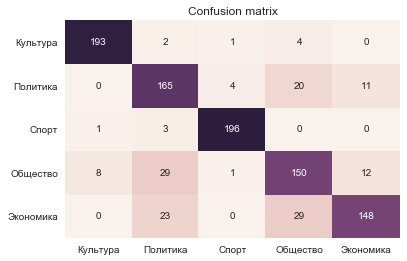

In [10]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_true, y_pred))
labels = test_corpus.topic.unique()
y_true = le.inverse_transform(y_true)
y_pred = le.inverse_transform(y_pred)
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [11]:
sequences = tokenizer.texts_to_sequences(train_corpus.body)
X_train = pad_sequences(sequences, maxlen=TEXT_LENGTH)
sequences = tokenizer.texts_to_sequences(test_corpus.body)
X_test = pad_sequences(sequences, maxlen=TEXT_LENGTH)

In [12]:
X_train[0]

array([  0,   0,   0, ...,   3, 931, 191], dtype=int32)

In [13]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=TEXT_LENGTH))
model.add(Flatten())
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 516s 57ms/step - loss: 1.7609 - acc: 0.6944 - val_loss: 0.5359 - val_acc: 0.7950

In [14]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

             precision    recall  f1-score   support

   Культура       0.95      0.97      0.96       200
   Общество       0.76      0.80      0.78       200
   Политика       0.76      0.81      0.79       200
      Спорт       0.99      0.98      0.99       200
  Экономика       0.87      0.75      0.81       200

avg / total       0.87      0.86      0.86      1000



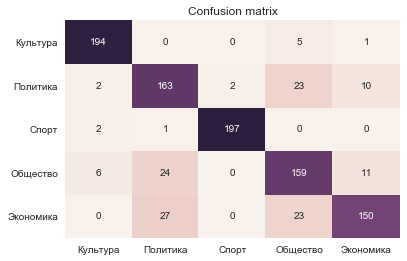

In [15]:
print(classification_report(y_true, y_pred))
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [16]:
%%time
emb_path = '/NLP/embeddings/wiki.ru.vec'

embeddings_index = {}
f = open(emb_path)
for line in f:
    values = line.split()
    if len(values) == 301:
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

CPU times: user 2min 27s, sys: 6.02 s, total: 2min 33s
Wall time: 2min 35s


In [17]:
print(len(embeddings_index))

1775997


In [18]:
word_index = tokenizer.word_index
len(word_index)

169523

In [19]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=TEXT_LENGTH,
                            trainable=False))
model.add(Flatten())
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)


Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 33s 4ms/step - loss: 0.6966 - acc: 0.7811 - val_loss: 0.7116 - val_acc: 0.7880

In [21]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

             precision    recall  f1-score   support

   Культура       0.92      0.93      0.92       200
   Общество       0.69      0.70      0.70       200
   Политика       0.66      0.78      0.72       200
      Спорт       0.98      0.97      0.97       200
  Экономика       0.84      0.67      0.74       200

avg / total       0.82      0.81      0.81      1000



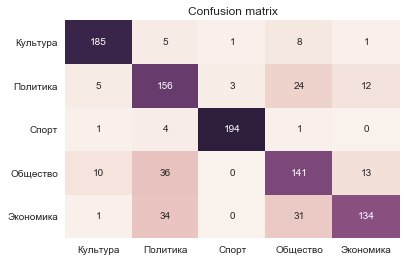

In [22]:
print(classification_report(y_true, y_pred))
sns.heatmap(data=confusion_matrix(y_true, y_pred, labels = labels), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## Сверточные нейронные сети [Convolutional neural networks, CNN]

* Заимствованы из области компьютерного зрения
* Пик популярности пришелся на 2014 (до +10% аккуратности в задачах классификации), со временем были вытеснены рекуррентными нейронными сетями 
* Помогают справится  с проблемой переменной длины входов (CNN VS window-based NN)

### Слой свертки

#### Фильтр [filter]:
* $n$ – размер окна (длина фильтра)
* $x_i \in \mathbb{R}^2$ – входные вектора слова
* $W \in \mathbb{R}^{1 \times l}$ – матрица весов, задает размерность фильтра 
* $b \in \mathbb{R}$ – сдвиг
* $l \in \mathbb{R}$ – длина входного вектора


<img src="img/cnn1.png" width="600">

$ h_i = \texttt{tanh} (W \begin{pmatrix}
           x_{i-1} \\
           x_{i} \\
           x_{i+1}
         \end{pmatrix} +b) $

Преобразуем каждое входное окно, но пока размерность входа не уменьшается!

#### Слой субдискретизации (пулинга, [pooling])

* $h_i$ – выходные значения фильтра

$\max$-пулинг:	$c = \max_i h_i$


<img src="img/cnn2.png" width="600">

* Выбираем самый важный признак из полученных на предыдущем шаге 
* Можем использовать и $\min$, и усреднение



### Классификатор на основе сверточной сети

* $y \in [0,1] $ - истинные значения
* $\hat{y} = c$ - предсказанные значения

<img src="img/cnn3.png" width="500">

Для обучения сверточной сети можно использовать обычный алгоритм распространения ошибки

Одномерные фильтры – это сильное ограничение. Что делать, если $c=0.5$?

#### Многомерные фильтры

* $W \in \mathbb{R}^{k \times l}$ – матрица весов, задает размерность фильтра

<img src="img/cnn4.png" width="500">

Фильтр:	
$h_i = \texttt{tanh} (W \begin{pmatrix}
           x_{i-1} \\
           x_{i} \\
           x_{i+1}
         \end{pmatrix} +b) \in \mathbb{R}^{k}$

$\max$-пулинг:	$c_j = \max_i h_{i,j}, j \in [0,k]$


#### Шаг окна 
Можно использовать непересекающиеся окна, чтобы уменьшить объем вычисления

<img src="img/cnn5.png" width="600">

### Как выбирать вектора слов? 
* Случайная инициализация (если нет обученных моделей word2vec, GloVe)
* word2vec, GloVe без обновления
* word2vec, GloVe c обновлением на каждой эпохе (увеличивается количество параметров!)
* Несколько каналов: копируем два входа и
    * на один подаем word2vec и не обновляем эти входы во время обучения, на второй подаем word2vec и обновляем эти входы во время обучения
    * на один вход подаем word2vec, на второй – GloVe

### Как использовать pad?

[[мое первое короткое предложение], [второе очень длинное предложение, которое никогда не заканчивается], [третье предложение]]

* Неэффективный способ: одно предложение – одна эпоха
* Окружить все предложения баластными символами pad и сделать их одной длины
* Надо убедиться, что $\max$-пулинг не выберет значения, соответствующие pad
* Надо убрать выбросы, то есть, супер-длинные предложения, возникшие, например, из-за ошибок сегментатора

## Классификация текстов с помощью CNN



<img src="img/cnn6.png" width="600">

In [23]:
embedding_layer = Embedding(VOCABULARY_SIZE,
                            EMBEDDING_DIM,
                            input_length=TEXT_LENGTH,
                            trainable=True)


sequence_input = Input(shape=(TEXT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
preds = Dense(len(train_corpus.topic.unique()), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

In [24]:
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=128, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 661s 73ms/step - loss: 1.5360 - acc: 0.3160 - val_loss: 1.7289 - val_acc: 0.1900

In [59]:
predictions = model.predict(X_test)

def probs_to_classes(probas):
    classes = np.zeros(probas.shape, dtype=np.int)
    for i, row in enumerate(probas):
        classes[i, np.argmax(row)] = 1
    return classes



y_pred = probs_to_classes(predictions)

In [60]:
print(classification_report(y_test, y_pred, target_names=labels))

             precision    recall  f1-score   support

   Культура       0.93      0.95      0.94       200
   Политика       0.75      0.78      0.76       200
      Спорт       0.76      0.83      0.79       200
   Общество       0.98      0.97      0.98       200
  Экономика       0.87      0.74      0.80       200

avg / total       0.86      0.85      0.85      1000

